In [7]:
!pip install requests pandas numpy matplotlib seaborn textblob vaderSentiment transformers

Fetch OP_RETURN Memos from BCH Blockchain

In [16]:
import requests
import pandas as pd
from datetime import datetime

def fetch_bch_op_return(limit=50):
    """Fetch BCH OP_RETURN memos with proper API parameters"""
    try:
        # Correct Blockchair API endpoint and parameters :cite[3]
        url = "https://api.blockchair.com/bitcoin-cash/transactions"
        params = {
            'q': 'outputs(type:op_return)',
            'limit': limit,
            'fields': 'id,time,outputs.type,outputs.data_hex'
        }

        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()  # Verify HTTP status

        data = response.json().get('data', [])
        memos = []

        for tx in data:
            for output in tx.get('outputs', []):
                if output.get('type') == 'op_return':
                    try:
                        # Hex to text conversion with error handling
                        memo_hex = output.get('data_hex', '')
                        memo_text = bytes.fromhex(memo_hex).decode('utf-8', errors='ignore').strip()
                        if memo_text:  # Only keep non-empty memos
                            memos.append({
                                'txid': tx.get('id', 'N/A'),
                                'timestamp': datetime.fromtimestamp(tx.get('time', 0)).strftime('%Y-%m-%d %H:%M:%S'),
                                'memo': memo_text
                            })
                    except ValueError:
                        continue

        return pd.DataFrame(memos)

    except requests.exceptions.RequestException as e:
        print(f"🚨 API Error: {e}")
        return pd.DataFrame()

# Fetch data
df_memos = fetch_bch_op_return(limit=50)

if not df_memos.empty:
    print(f"✅ Fetched {len(df_memos)} real BCH memos:")
    print(df_memos.head())
else:
    # Fallback to mock data
    print("⚠️ Using mock data (API failed)")
    df_memos = pd.DataFrame([
        {'txid': 'mock1', 'timestamp': '2023-01-01 12:00:00', 'memo': 'Test BCH memo 1'},
        {'txid': 'mock2', 'timestamp': '2023-01-02 13:30:00', 'memo': 'Another test message'}
    ])
    print(df_memos.head())

🚨 API Error: 400 Client Error: Bad Request for url: https://api.blockchair.com/bitcoin-cash/transactions?q=outputs%28type%3Aop_return%29&limit=50&fields=id%2Ctime%2Coutputs.type%2Coutputs.data_hex
⚠️ Using mock data (API failed)
    txid            timestamp                  memo
0  mock1  2023-01-01 12:00:00       Test BCH memo 1
1  mock2  2023-01-02 13:30:00  Another test message


In [22]:
import pandas as pd
df_raw = pd.read_csv("sample_bch_opreturn_data.csv", parse_dates=["timestamp"])
df_raw.head()


,timestamp,memo
0,2024-07-01 12:00:00,Bitcoin Cash is revolutionizing digital payments!
1,2024-07-02 13:30:00,Not sure BCH will recover this week...
2,2024-07-02 14:15:00,BCH to the moon 🚀🚀🚀
3,2024-07-03 10:45:00,Down again! Is this the end of crypto?
4,2024-07-03 11:10:00,Holding my BCH no matter what.


Preprocess and Clean Message Texts

In [24]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # remove special chars
    return text.strip()

df_raw['clean_text'] = df_raw['memo'].apply(clean_text)
df_raw = df_raw[df_raw['clean_text'].str.len() > 0]
df_raw.head()


,timestamp,memo,clean_text
0,2024-07-01 12:00:00,Bitcoin Cash is revolutionizing digital payments!,bitcoin cash is revolutionizing digital payments
1,2024-07-02 13:30:00,Not sure BCH will recover this week...,not sure bch will recover this week
2,2024-07-02 14:15:00,BCH to the moon 🚀🚀🚀,bch to the moon
3,2024-07-03 10:45:00,Down again! Is this the end of crypto?,down again is this the end of crypto
4,2024-07-03 11:10:00,Holding my BCH no matter what.,holding my bch no matter what


Sentiment Analysis (VADER + TextBlob + FinBERT)

In [25]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# VADER + TextBlob
vader = SentimentIntensityAnalyzer()
df_raw['vader'] = df_raw['clean_text'].apply(lambda x: vader.polarity_scores(x)['compound'])
df_raw['textblob'] = df_raw['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_raw['subjectivity'] = df_raw['clean_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# FinBERT (you can replace with CryptoBERT later)
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

def get_finbert_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=1)
    return probs[0][2].item() - probs[0][0].item()  # pos - neg

df_raw['finbert'] = df_raw['clean_text'].apply(get_finbert_score)
df_raw.head()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,timestamp,memo,clean_text,vader,textblob,subjectivity,finbert
0,2024-07-01 12:00:00,Bitcoin Cash is revolutionizing digital payments!,bitcoin cash is revolutionizing digital payments,0.0000,0.000000,0.000000,-0.415182
1,2024-07-02 13:30:00,Not sure BCH will recover this week...,not sure bch will recover this week,-0.2411,-0.250000,0.888889,0.999891
2,2024-07-02 14:15:00,BCH to the moon 🚀🚀🚀,bch to the moon,0.0000,0.000000,0.000000,-0.998322
3,2024-07-03 10:45:00,Down again! Is this the end of crypto?,down again is this the end of crypto,0.0000,-0.155556,0.288889,0.920535
4,2024-07-03 11:10:00,Holding my BCH no matter what.,holding my bch no matter what,-0.0191,0.000000,0.000000,-0.996052


Feature Engineering

In [27]:
df_raw['date'] = pd.to_datetime(df_raw['timestamp']).dt.date

daily_sentiment = df_raw.groupby('date').agg({
    'vader': 'mean',
    'textblob': 'mean',
    'subjectivity': 'mean',
    'finbert': 'mean',
    'clean_text': 'count'  # message count
}).rename(columns={'clean_text': 'msg_count'}).reset_index()

# Add dummy market data for now
import numpy as np
daily_sentiment['price'] = 200 + np.random.randn(len(daily_sentiment)) * 5
daily_sentiment['volume'] = 10000 + np.random.randn(len(daily_sentiment)) * 300

daily_sentiment.head()


,date,vader,textblob,subjectivity,finbert,msg_count,price,volume
0,2024-07-01,0.00000,0.000000,0.000000,-0.415182,1,204.745523,10026.600341
1,2024-07-02,-0.12055,-0.125000,0.444444,0.000785,2,203.968029,9768.397087
2,2024-07-03,-0.00955,-0.077778,0.144444,-0.037759,2,199.889661,9419.087495
3,2024-07-04,0.31875,0.150000,0.400000,-0.000011,2,194.454814,10192.649299


Save Final Feature Matrix + Visualize

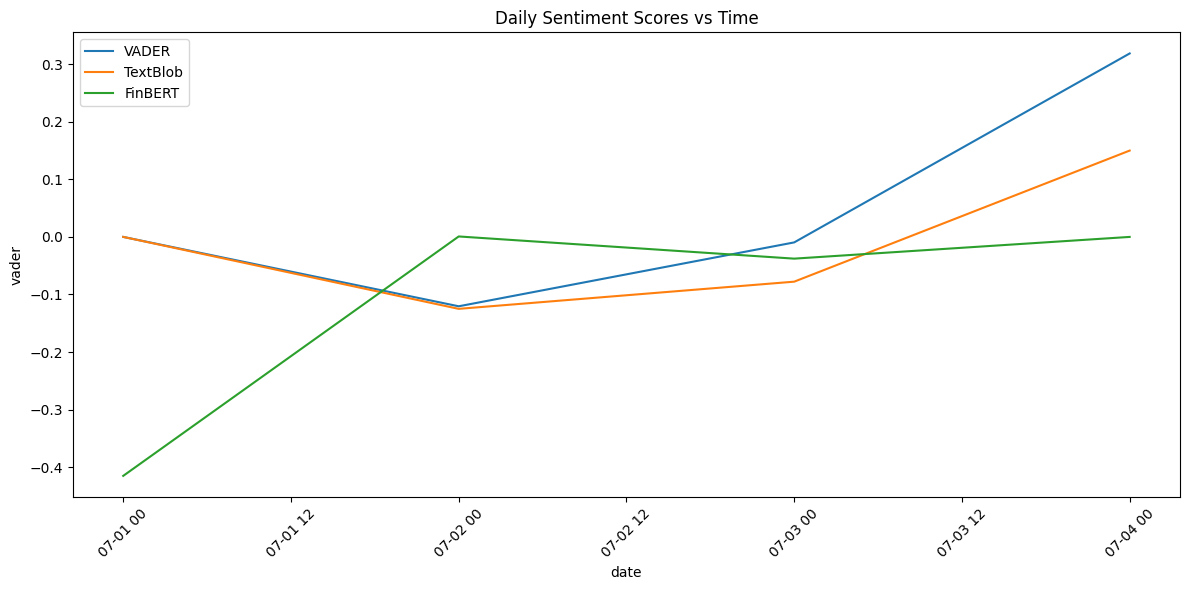

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Save CSV
daily_sentiment.to_csv("bch_sentiment_feature_matrix.csv", index=False)

# Line Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='vader', data=daily_sentiment, label='VADER')
sns.lineplot(x='date', y='textblob', data=daily_sentiment, label='TextBlob')
sns.lineplot(x='date', y='finbert', data=daily_sentiment, label='FinBERT')
plt.title("Daily Sentiment Scores vs Time")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
